# 목차

### 0. Import
 - [library import](#library-import)
 - [file import](#file-import)

### 1. Feature Preprocessing 
- [Missing Value](#Missing-Value)
- [Outlier](#Outlier)

### 2. Feature Engineering

### 3. Feature Generation
- [나이](#나이)
- [나이 대비 소득 수준](#나이-대비-소득-수준)
- [경력 공백기간](#경력-공백기간)
- [ID](#ID)
- [가구당 소득](#가구당-소득)
- [income_level_q](#income_level_q)
- [가족수+-자식수](#가족수+-자식수)
- [income_level_age](#income_level_age)
- [occyp_type 파생변수](#occyp_type-파생변수)
- [분류별 begin_month 평균 & 연간 소득 평균](#분류별-begin_month-평균-&-연간-소득-평균)

### 4. Encoding
- [Ordinal Encoding](#Ordinal-Encoding)
- [Label Encoding](#Label-Encoding)

### 5. Scaling
- [MinMax_Scale](#MinMax_Scale)
- [Standard_Scale](#Standard_Scale)
- [Robust_Scale](#Robust_Scale)
- [Log_Scale](#Log_Scale)
- [After_Scale](#After_Scale)

### 6. Feature Selection
- [corr-method](#corr-method)
- [feature-method](#feature-method)

### 7. Modeling
- [train,test,features split](#train,test,features-split)
- [Pipeline](#Pipeline)
- [catboost](#catboost)

# 0.Import

### library import

In [227]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import PowerTransformer 
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.feature_selection import SelectPercentile
from sklearn import set_config
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer 
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.feature_selection import SelectPercentile, SelectKBest
from sklearn.model_selection import train_test_split, KFold, cross_validate, ShuffleSplit
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import mean_squared_error
from sklearn import set_config
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestClassifier
import re
import statsmodels.api as sm
import seaborn as sns
import klib

plt.rc('font', family='Malgun Gothic') # 폰트 지정
plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정
%config InlineBackend.figure_format='retina' # 그래프 글씨 뚜렷

from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import log_loss
import missingno as msno
import matplotlib.pyplot as plt

from optuna.distributions import CategoricalDistribution, IntDistribution, FloatDistribution
from optuna.integration import OptunaSearchCV
import optuna

### file import

In [228]:
X_train = pd.read_csv('train.csv', encoding='cp949').drop(columns='credit')
y_train = pd.read_csv('train.csv', encoding='cp949').credit
X_test = pd.read_csv('test.csv',encoding='cp949')
submission = pd.read_csv("sample_submission.csv")

In [229]:
X = pd.concat([X_train,X_test], ignore_index=True)

# 1. Feature Preprocessing & Engineering

### Missing Value

<AxesSubplot:>

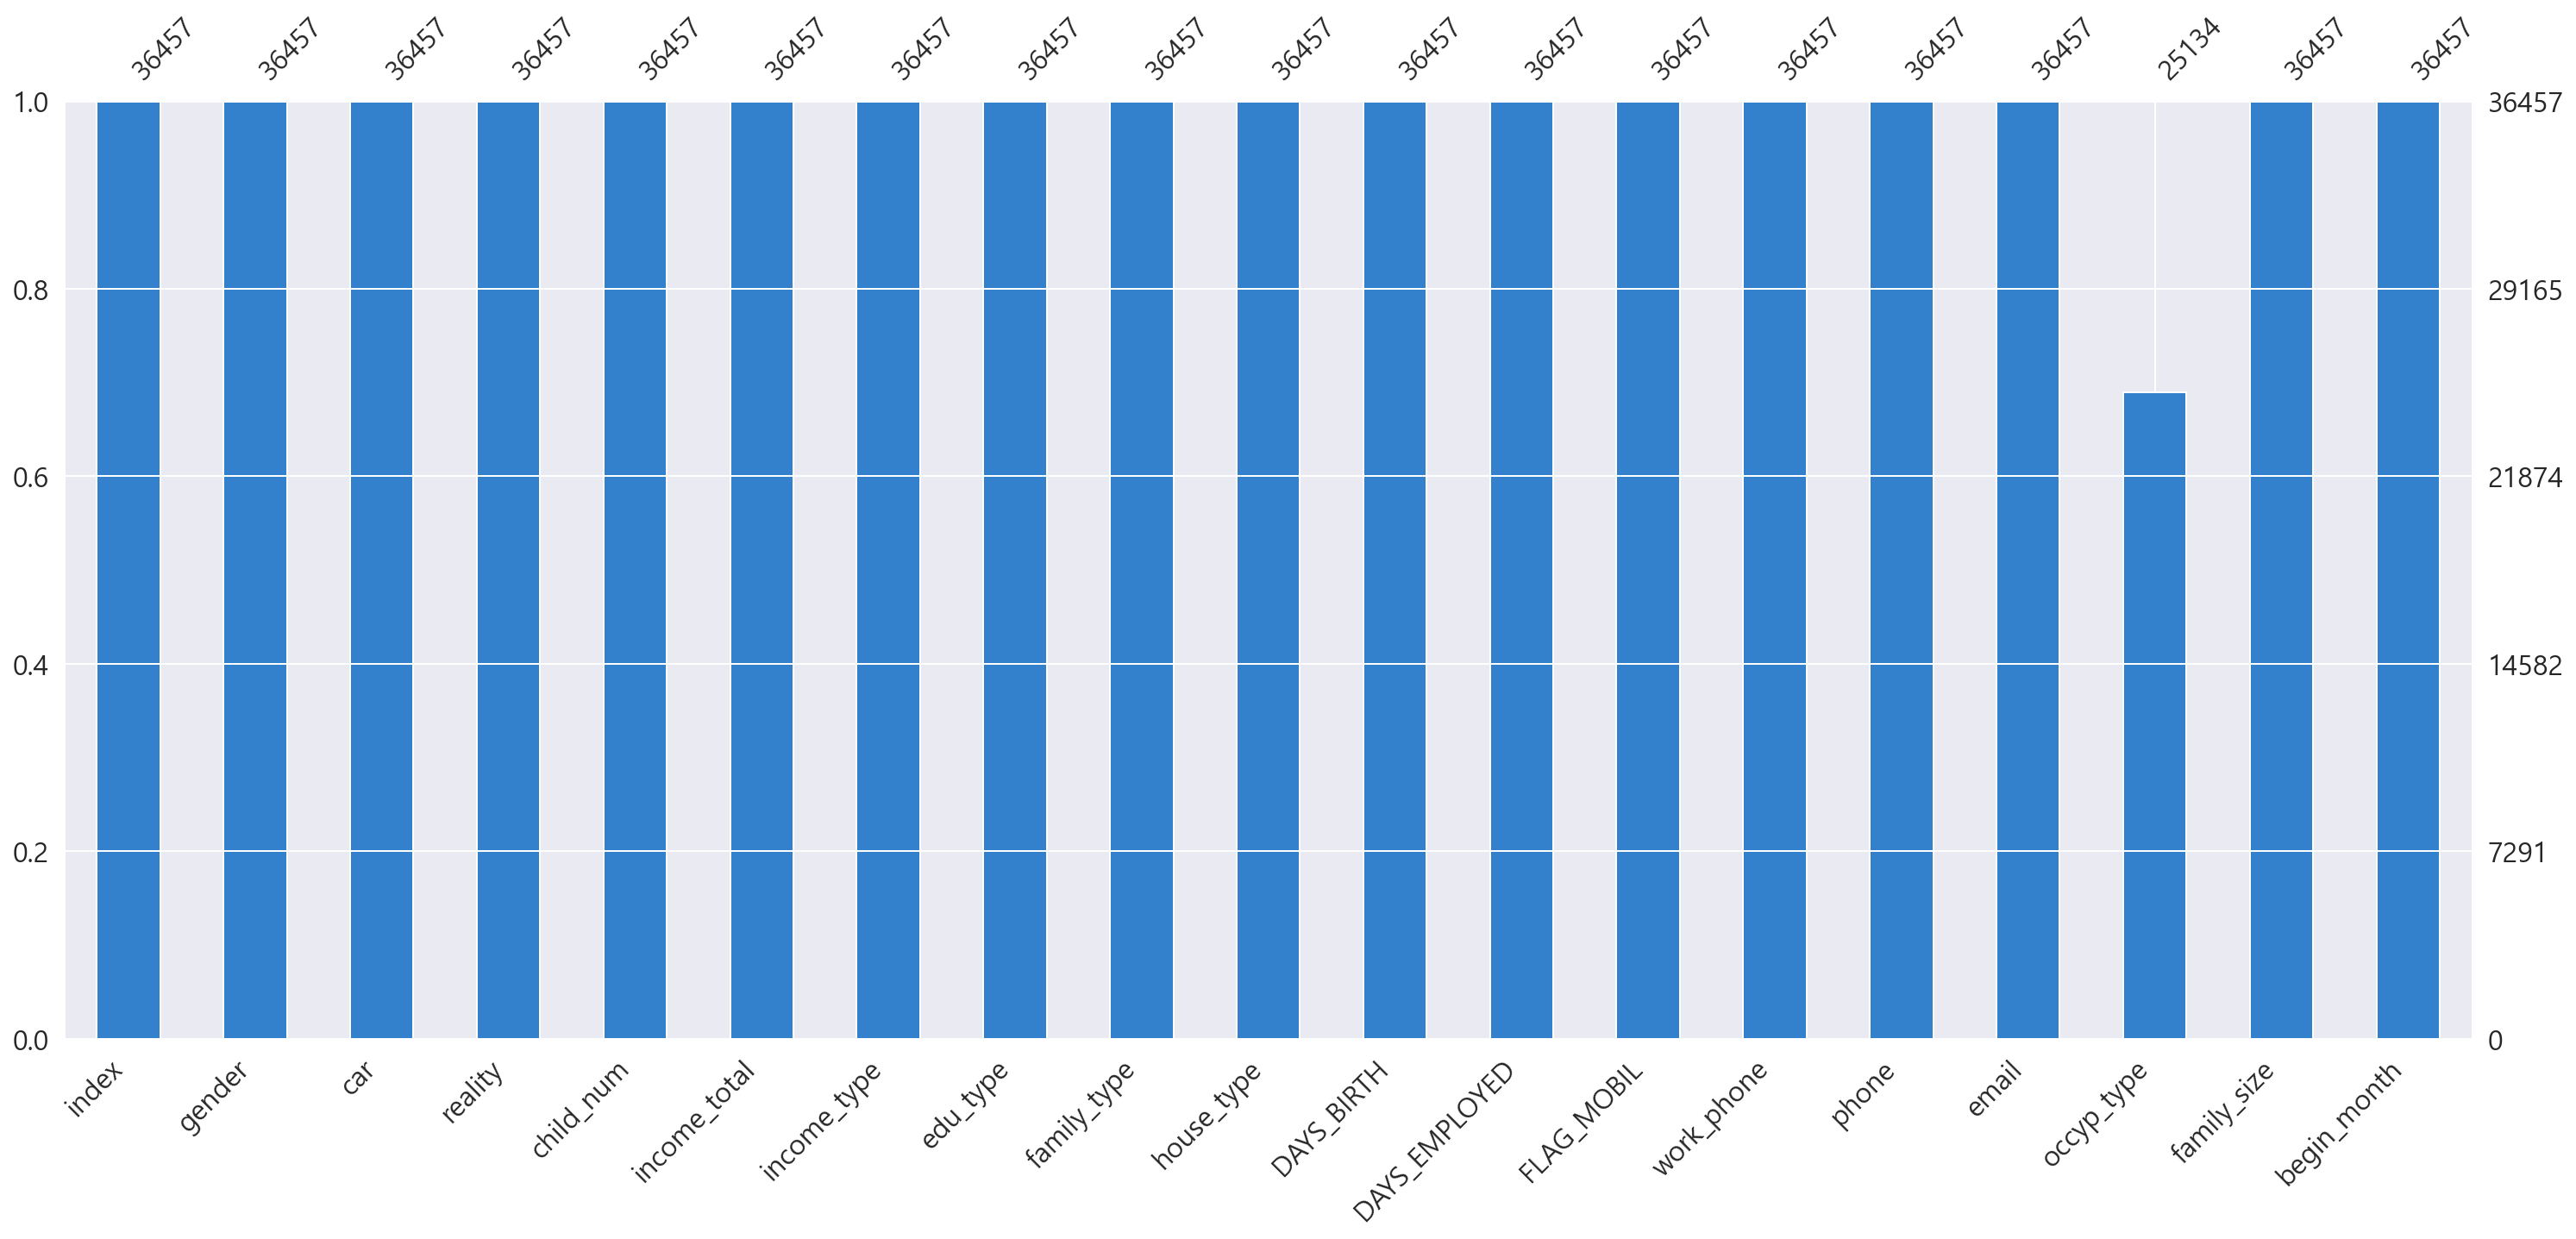

In [230]:
#결측치 시각화
msno.bar(df=X.iloc[:,:],color=(0.2,0.5,0.8))

In [231]:
X.isnull().sum()

index                0
gender               0
car                  0
reality              0
child_num            0
income_total         0
income_type          0
edu_type             0
family_type          0
house_type           0
DAYS_BIRTH           0
DAYS_EMPLOYED        0
FLAG_MOBIL           0
work_phone           0
phone                0
email                0
occyp_type       11323
family_size          0
begin_month          0
dtype: int64

- occyp_type 결측값 NaN으로 대체

In [232]:
X['occyp_type'] = X['occyp_type'].fillna('NaN')

### Outlier

- family_size 7 이상 제거

In [233]:
X['family_size'] = X['family_size'].clip(0,7)

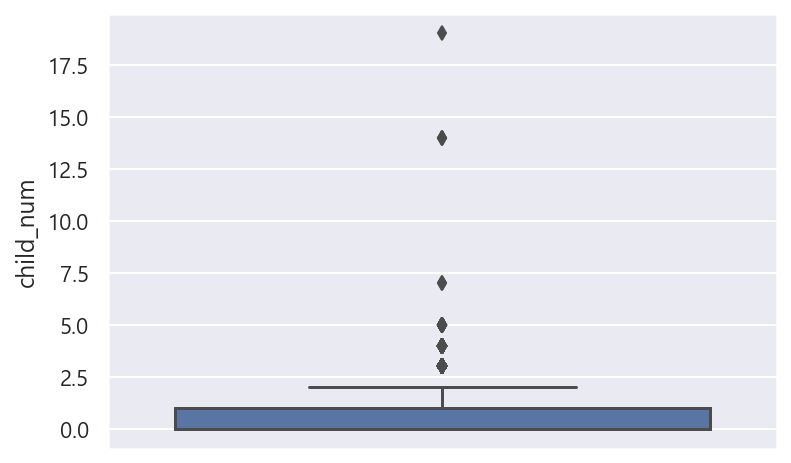

In [234]:
sns.boxplot(data = X, y='child_num')
plt.show()

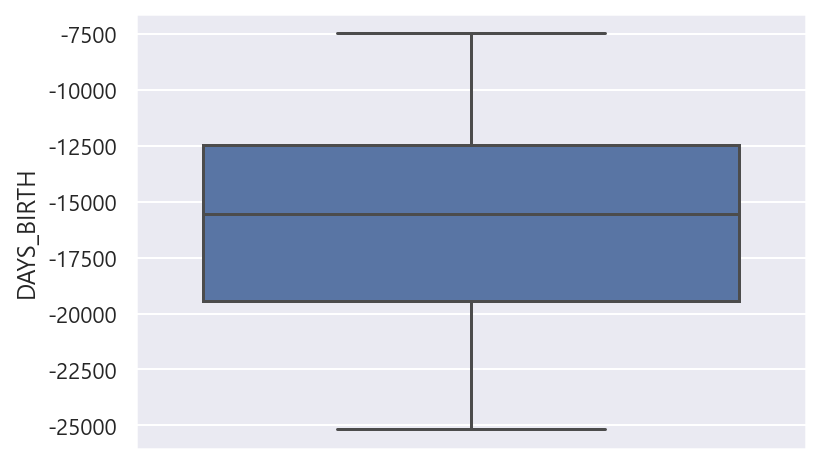

In [235]:
sns.boxplot(data = X, y='DAYS_BIRTH')
plt.show()

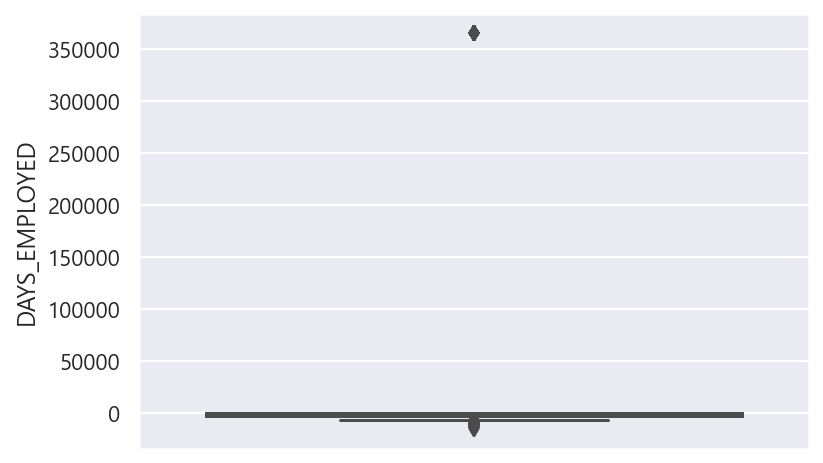

In [236]:
sns.boxplot(data = X, y='DAYS_EMPLOYED')
plt.show()

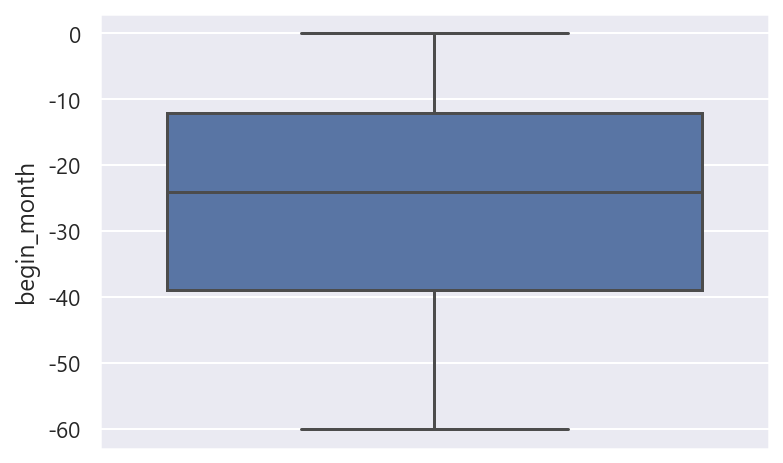

In [237]:
sns.boxplot(data = X, y='begin_month')
plt.show()

- boxplot > IQR 범위 벗어나는 값 이상치로 간주 > 제거

In [238]:
columns = ['child_num', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month']
for col in columns:
    q1=X[col].quantile(0.25)
    q3=X[col].quantile(0.75)
    IQR=q3-q1
    # 소수점(1.5, 2.5) 형태로 나와서 올림 처리
    line_down = math.ceil(q1 - IQR * 1.5)
    line_up = math.ceil(q3 + IQR * 1.5) 
    
    X[col] = X[col].clip(line_down, line_up)

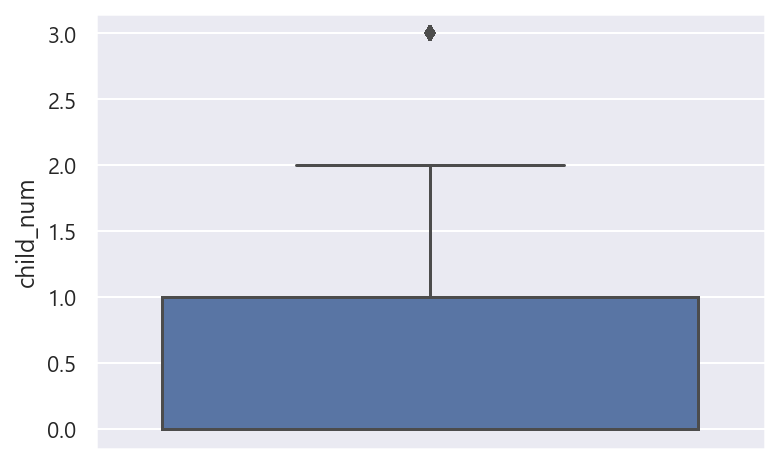

In [239]:
sns.boxplot(data = X, y='child_num')
plt.show()

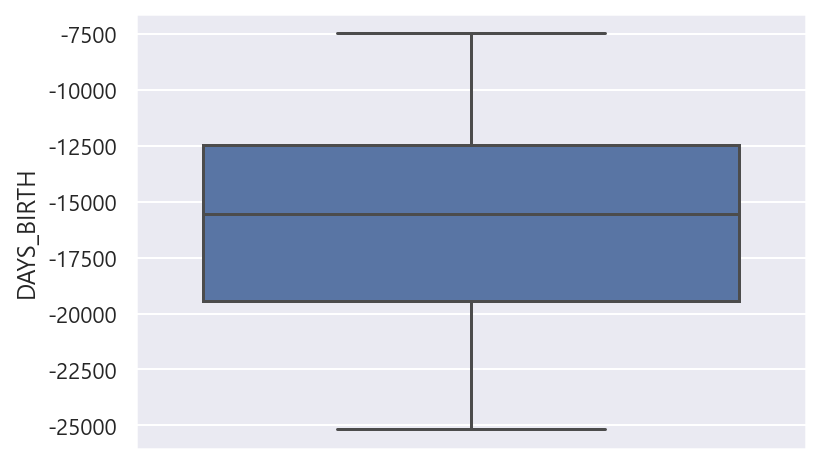

In [240]:
sns.boxplot(data = X, y='DAYS_BIRTH')
plt.show()

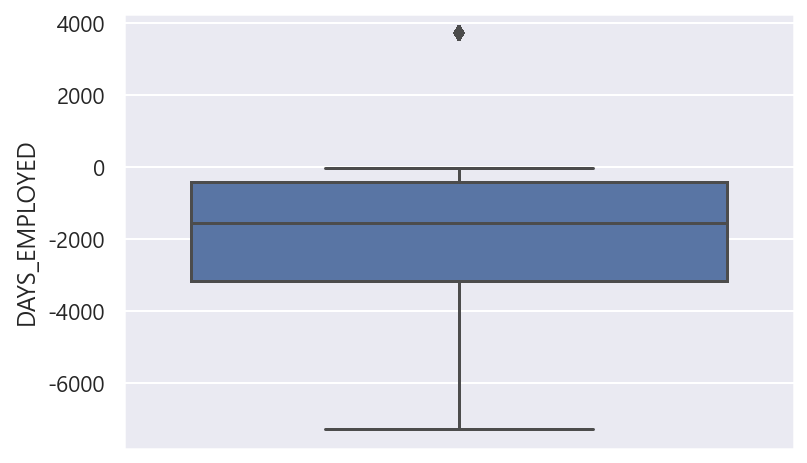

In [241]:
sns.boxplot(data = X, y='DAYS_EMPLOYED')
plt.show()

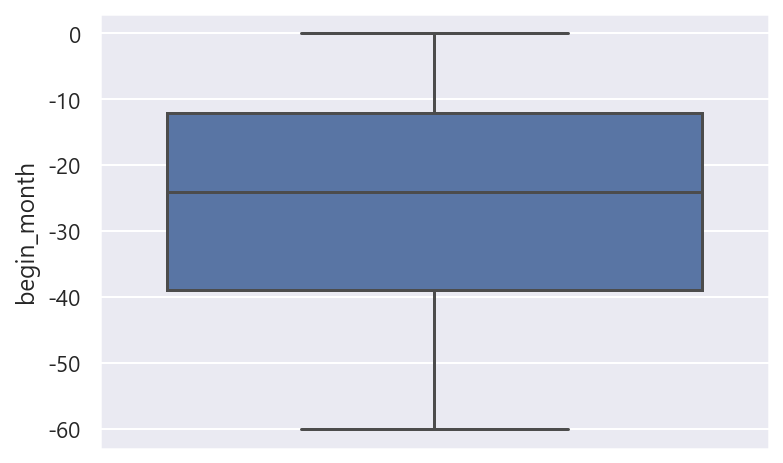

In [242]:
sns.boxplot(data = X, y='begin_month')
plt.show()

# 2. Feature Engineering

- DAYS_EMPLOYED: 0 이상 미고용상태이므로 0으로 대체

In [243]:
X['DAYS_EMPLOYED'] = X['DAYS_EMPLOYED'].map(lambda x: 0 if x > 0 else x)

- DAYS_BIRTH, DAYS_EMPLOYED, begin_month: 양수로 변환

In [244]:
feats = ['DAYS_BIRTH', 'begin_month', 'DAYS_EMPLOYED']
for feat in feats:
    X[feat]=np.abs(X[feat])

- FLAG_MOBIL: 값이 모두 동일하므로 DROP

In [245]:
X.drop('FLAG_MOBIL', axis=1, inplace=True)

- index: 필요없으므로 제거

In [246]:
X.drop('index', axis=1, inplace=True)

# 3. Feature Generation

### 나이

In [247]:
# 나이는 정수이기에 몫으로 사용
X['Age'] = X['DAYS_BIRTH'] // 365 

In [248]:
#태어난 월
X['DAYS_BIRTH_m'] = np.floor(X['DAYS_BIRTH'] / 30) - ((np.floor(X['DAYS_BIRTH'] / 30) / 12).astype(int) * 12)
#태어난 주
X['DAYS_BIRTH_w'] = np.floor(X['DAYS_BIRTH'] / 7) - ((np.floor(X['DAYS_BIRTH'] / 7) / 4).astype(int) * 4)

### 나이 대비 소득 수준

In [249]:
X['income_level_age'] = X['income_total'] / X['Age']

- 업무 시작일(일) - 신용카드 발급 이후 기간(월 > 일로 변환)
    + 양수이면 취직 후 신용카드를 발급 받은 것으로 신용도가 높을 것으로 가정
    + 음수이면 취직 전 신용카드를 발급 받은 것으로 취직 후에 비해 상대적으로 신용도가 낮을 것으로 가정

In [250]:
X['distance_creditcard_employed']= X['DAYS_EMPLOYED'] - X['begin_month'] * 30

### 경력 공백기간

- 고용되기 전까지의 일, 월, 주, 비율

In [251]:
X['before_EMPLOYED'] = X['DAYS_BIRTH'] - X['DAYS_EMPLOYED']
X['before_EMPLOYED_m'] = np.floor(X['before_EMPLOYED'] / 30) - ((np.floor(X['before_EMPLOYED'] / 30) / 12).astype(int) * 12)
X['before_EMPLOYED_w'] = np.floor(X['before_EMPLOYED'] / 7) - ((np.floor(X['before_EMPLOYED'] / 7) / 4).astype(int) * 4)
X['income_total_beforeEMP_ratio'] = X['income_total'] / X['before_EMPLOYED']

### ID

- 신용도 판단에 유의미한 방향으로 개인을 식별(특정) 할 수 있는 features를 합하여 ID 생성

In [252]:
X['ID'] = \
X['child_num'].astype(str) + '_' + X['income_total'].astype(str) + '_' +\
X['DAYS_BIRTH'].astype(str) + '_' + X['DAYS_EMPLOYED'].astype(str) + '_' +\
X['work_phone'].astype(str) + '_' + X['phone'].astype(str) + '_' +\
X['email'].astype(str) + '_' + X['family_size'].astype(str) + '_' +\
X['gender'].astype(str) + '_' + X['car'].astype(str) + '_' +\
X['reality'].astype(str) + '_' + X['income_type'].astype(str) + '_' +\
X['edu_type'].astype(str) + '_' + X['family_type'].astype(str) + '_' +\
X['house_type'].astype(str) + '_' + X['occyp_type'].astype(str)

In [253]:
X['ID'] = X['ID'].fillna('0')

### 가구당 소득

In [254]:
X['income_family'] = X['income_total'] / X['family_size']

### income_level_q

- income_total level 을 지정 분위수 지정해서(4개 10개), 각각에 값을 할당해, income 값에 따라 분포하는 것을 보기 위함

In [255]:
X['income_level_q'] = np.zeros(36457)
X['income_level_d'] = np.zeros(36457)

X['income_level_q'][X['income_total'] < X['income_total'].quantile(0.25)] = 1

X['income_level_q'][(X['income_total'] >= X['income_total'].quantile(0.25)) &
                       (X['income_total'] < X['income_total'].quantile(0.5))] = 2

X['income_level_q'][(X['income_total'] >= X['income_total'].quantile(0.5)) &
                       (X['income_total'] < X['income_total'].quantile(0.75))] = 3

X['income_level_q'][X['income_total'] >= X['income_total'].quantile(0.75)] = 4

C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_6176\3424040329.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['income_level_q'][X['income_total'] < X['income_total'].quantile(0.25)] = 1
C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_6176\3424040329.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['income_level_q'][(X['income_total'] >= X['income_total'].quantile(0.25)) &
C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_6176\3424040329.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

### 가족수+-자식수

In [256]:
X['FAM_CHID_DIFF'] = X['family_size'] - X['child_num']
X['FAM_CHID_SUM'] = X['family_size'] + X['child_num']

### income_level_age

In [257]:
X['income_level_age'] = X['income_total'] / X['Age']

In [258]:
# DAYS_BIRTH
X['DAYS_BIRTH_month']=np.floor((X['DAYS_BIRTH'])/30)-((np.floor((X['DAYS_BIRTH'])/30)/12).astype(int)*12)
X['DAYS_BIRTH_week']=np.floor((X['DAYS_BIRTH'])/7)-((np.floor((X['DAYS_BIRTH'])/7)/4).astype(int)*4)

# DAYS_EMPLOYED
X['DAYS_EMPLOYED_month']=np.floor((X['DAYS_EMPLOYED'])/30)-((np.floor((X['DAYS_EMPLOYED'])/30)/12).astype(int)*12)
X['DAYS_EMPLOYED_week']=np.floor((X['DAYS_EMPLOYED'])/7)-((np.floor((X['DAYS_EMPLOYED'])/7)/4).astype(int)*4)

In [259]:
X['begin_day'] = X['begin_month'] * 30

### occyp_type 파생변수

In [260]:
X_train = X.iloc[:X_train.shape[0],:].reset_index(drop=True)
X_test = X.iloc[X_train.shape[0]:,:].reset_index(drop=True)
X_train['credit'] = y_train

In [261]:
X_train['occyp_type_2'] = 0
X_train['occyp_type_1'] = 0
X_train['occyp_type_0'] = 0
X_test['occyp_type_2'] = 0
X_test['occyp_type_1'] = 0
X_test['occyp_type_0'] = 0

for occ in X_train['occyp_type'].unique():
    occyp_quant = X_train.loc[X_train.occyp_type==occ ,'credit'].value_counts().values
    occyp_quant_rate = (occyp_quant/occyp_quant.sum()).round(2)*100
    X_train['occyp_type_2'][X_train['occyp_type'] == occ] = occyp_quant_rate[0]
    X_test['occyp_type_2'][X_test['occyp_type'] == occ] = occyp_quant_rate[0]
    X_train['occyp_type_1'][X_train['occyp_type'] == occ] = occyp_quant_rate[1]
    X_test['occyp_type_1'][X_test['occyp_type'] == occ] = occyp_quant_rate[1]
    X_train['occyp_type_0'][X_train['occyp_type'] == occ] = occyp_quant_rate[2]
    X_test['occyp_type_0'][X_test['occyp_type'] == occ] = occyp_quant_rate[2]

C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_6176\1835405897.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['occyp_type_2'][X_train['occyp_type'] == occ] = occyp_quant_rate[0]
C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_6176\1835405897.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['occyp_type_2'][X_test['occyp_type'] == occ] = occyp_quant_rate[0]
C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_6176\1835405897.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

In [262]:
X_train = X_train.drop('credit',axis=1)

### 분류별 begin_month 평균 & 연간 소득 평균

In [263]:
# 소득 분류 별 begin_month 평균 & 소득 분류 별 연간 소득 평균
X['income_type_begin_month_mean'] = X.groupby(['income_type'])['begin_month'].transform('mean')
X['income_type_income_total_mean'] = X.groupby(['income_type'])['income_total'].transform('mean')

# 교육 수준 별 begin_month 평균 & 교육 수준 별 연간 소득 평균
X['edu_type_begin_month_mean'] = X.groupby(['edu_type'])['begin_month'].transform('mean')
X['edu_type_income_total_mean'] = X.groupby(['edu_type'])['income_total'].transform('mean')

# 결혼 여부 별 begin_month 평균 & 결혼 여부 별 연간 소득 평균
X['family_type_begin_month_mean'] = X.groupby(['family_type'])['begin_month'].transform('mean')
X['family_type_income_total_mean'] = X.groupby(['family_type'])['income_total'].transform('mean')

# 생활 방식 별 begin_month 평균 & 생활 방식 별 연간 소득 평균
X['house_type_begin_month_mean'] = X.groupby(['house_type'])['begin_month'].transform('mean')
X['house_type_income_total_mean'] = X.groupby(['house_type'])['income_total'].transform('mean')

# 직업 유형 별 begin_month 평균 & 직업 유형 별 연간 소득 평균
X['occyp_type_begin_month_mean'] = X.groupby(['occyp_type'])['begin_month'].transform('mean')
X['occyp_type_income_total_mean'] = X.groupby(['occyp_type'])['income_total'].transform('mean')

# 4. Encoding

### Ordinal Encoding

In [268]:
ord_idx = ['ID']
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, dtype=int)
X[ord_idx] = pd.DataFrame(oe.fit_transform(X[ord_idx]))
X['ID']

0        3454
1        8116
2        5628
3        3490
4        2127
         ... 
36452    3592
36453    3389
36454    5043
36455    2938
36456    4925
Name: ID, Length: 36457, dtype: int32

### Label encoding

In [269]:
X['gender'] = X['gender'].replace(['F','M'],[0,1])

X['car'] = X['car'].replace(['N','Y'],[0,1])

X['reality'] = X['reality'].replace(['N','Y'],[0,1])

# 5. Scaling

In [270]:
numerical_feats = X.dtypes[X.dtypes != "object"].index.tolist()
numerical_feats.remove('income_total')
print(numerical_feats)

['gender', 'car', 'reality', 'child_num', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'work_phone', 'phone', 'email', 'family_size', 'begin_month', 'Age', 'DAYS_BIRTH_m', 'DAYS_BIRTH_w', 'income_level_age', 'distance_creditcard_employed', 'before_EMPLOYED', 'before_EMPLOYED_m', 'before_EMPLOYED_w', 'income_total_beforeEMP_ratio', 'ID', 'income_family', 'income_level_q', 'income_level_d', 'FAM_CHID_DIFF', 'FAM_CHID_SUM', 'DAYS_BIRTH_month', 'DAYS_BIRTH_week', 'DAYS_EMPLOYED_month', 'DAYS_EMPLOYED_week', 'begin_day', 'income_type_begin_month_mean', 'income_type_income_total_mean', 'edu_type_begin_month_mean', 'edu_type_income_total_mean', 'family_type_begin_month_mean', 'family_type_income_total_mean', 'house_type_begin_month_mean', 'house_type_income_total_mean', 'occyp_type_begin_month_mean', 'occyp_type_income_total_mean']


C:\Users\SAMSUNG\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


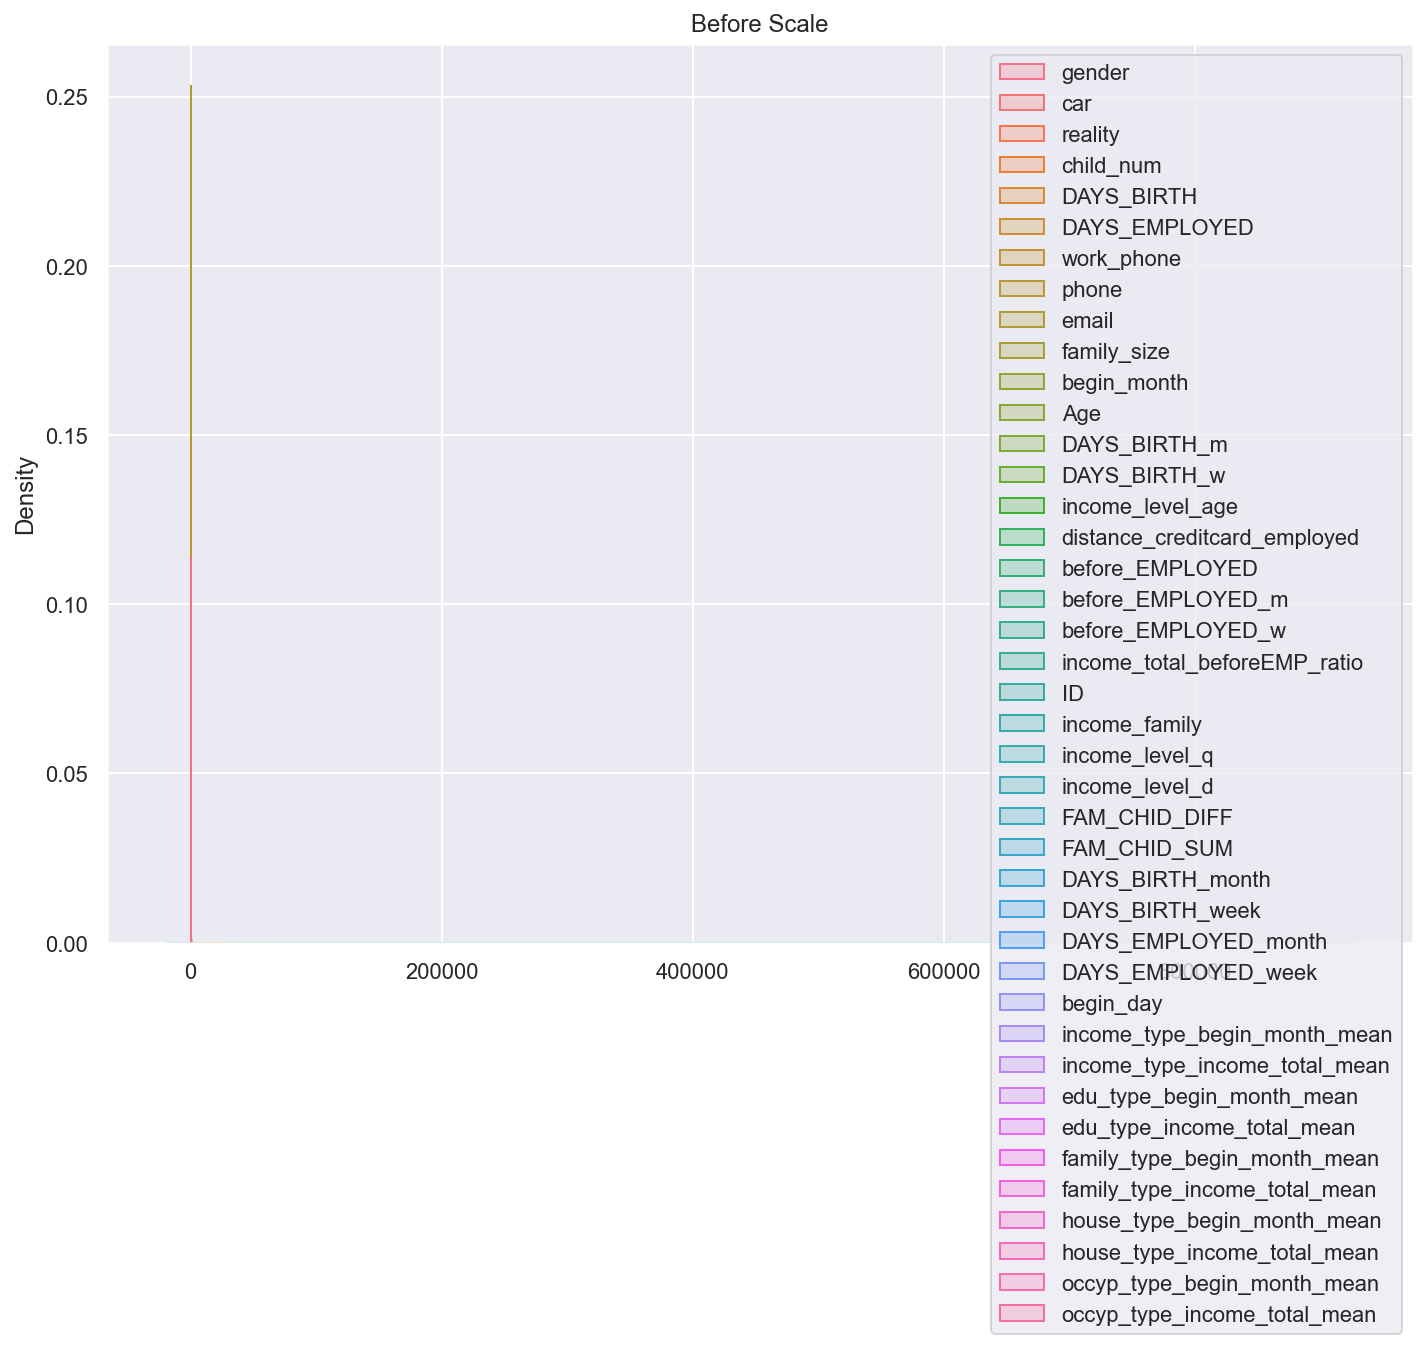

In [271]:
sns.set(rc={'figure.figsize':(11.7,8.27)},)
sns.kdeplot(data = X[numerical_feats], shade = True).set_title('Before Scale')
plt.show()

### MinMax_Scale

- income_total제외한 수치형 변수들 minmax scale

C:\Users\SAMSUNG\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


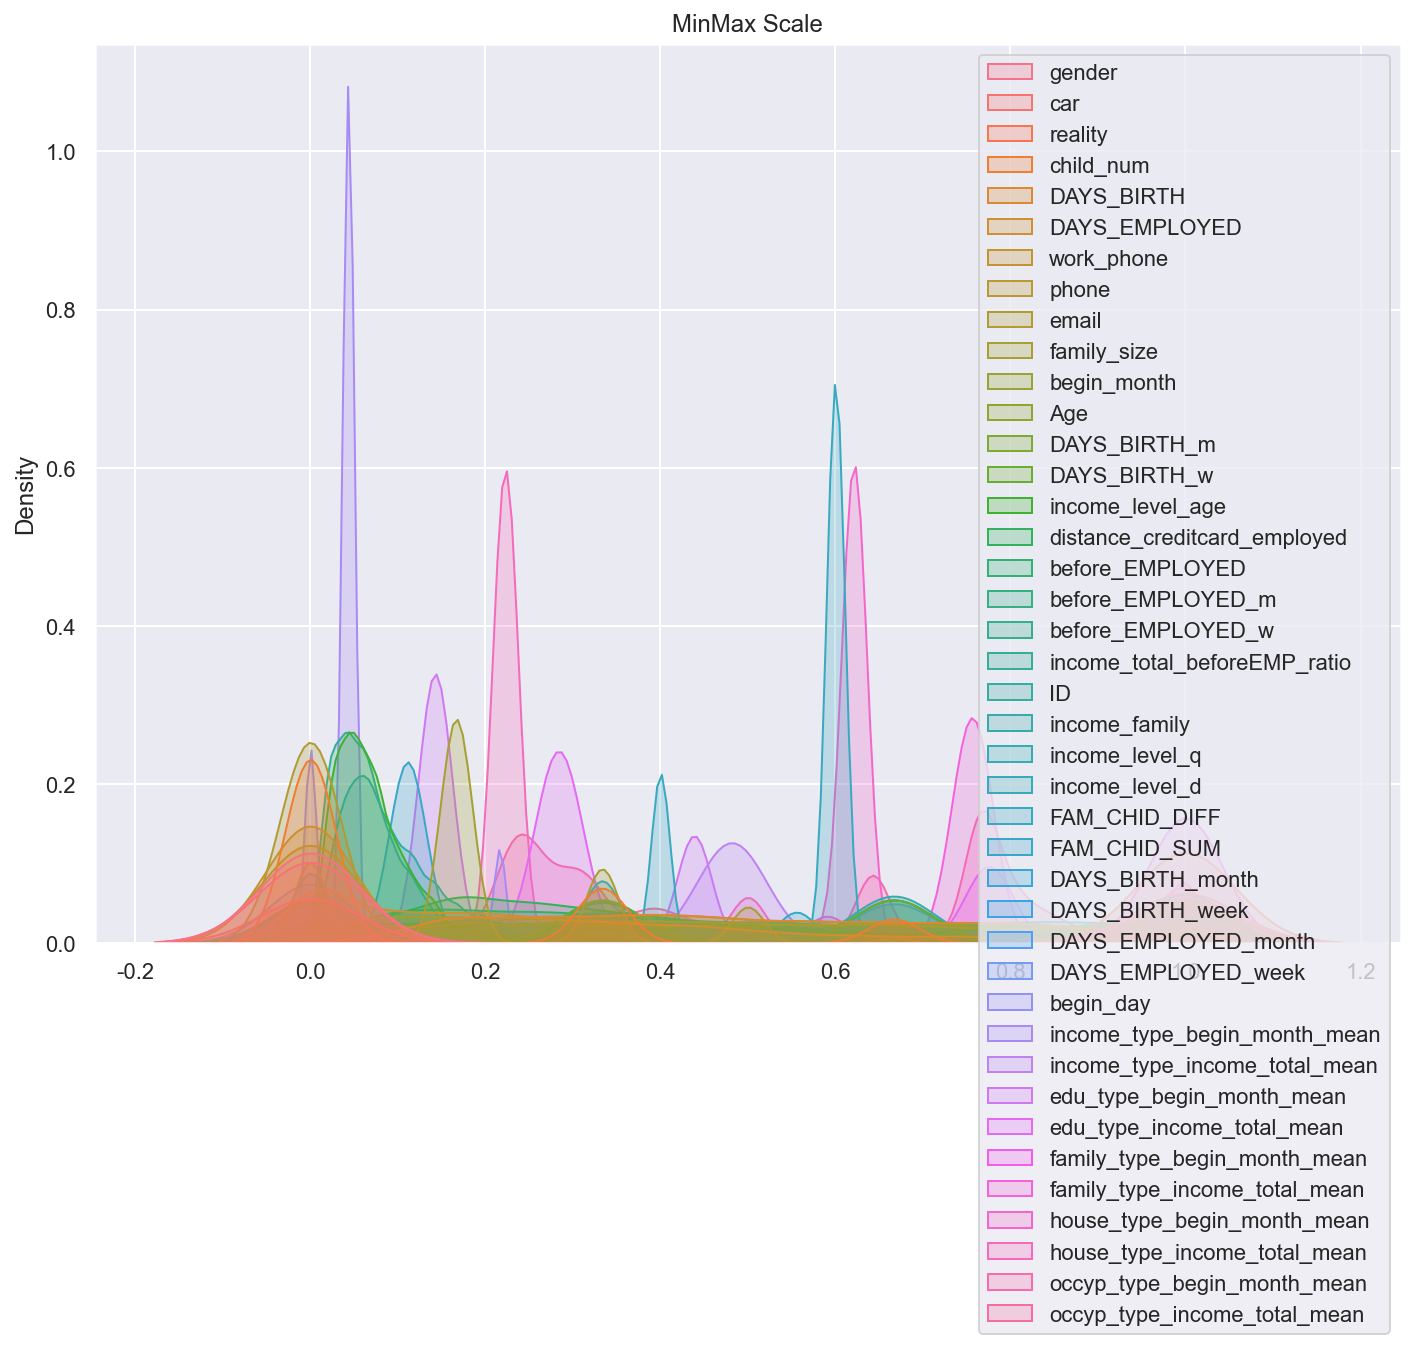

In [272]:
scaler = MinMaxScaler()
X_view1 = X.copy()
X_view1[numerical_feats] = scaler.fit_transform(X_view1[numerical_feats])

sns.set(rc={'figure.figsize':(11.7,8.27)},)
sns.kdeplot(data = X_view1[numerical_feats], shade = True).set_title('MinMax Scale')
plt.show()

### Standard_Scale

- income_total제외한 수치형 변수들 Standard Scale

C:\Users\SAMSUNG\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


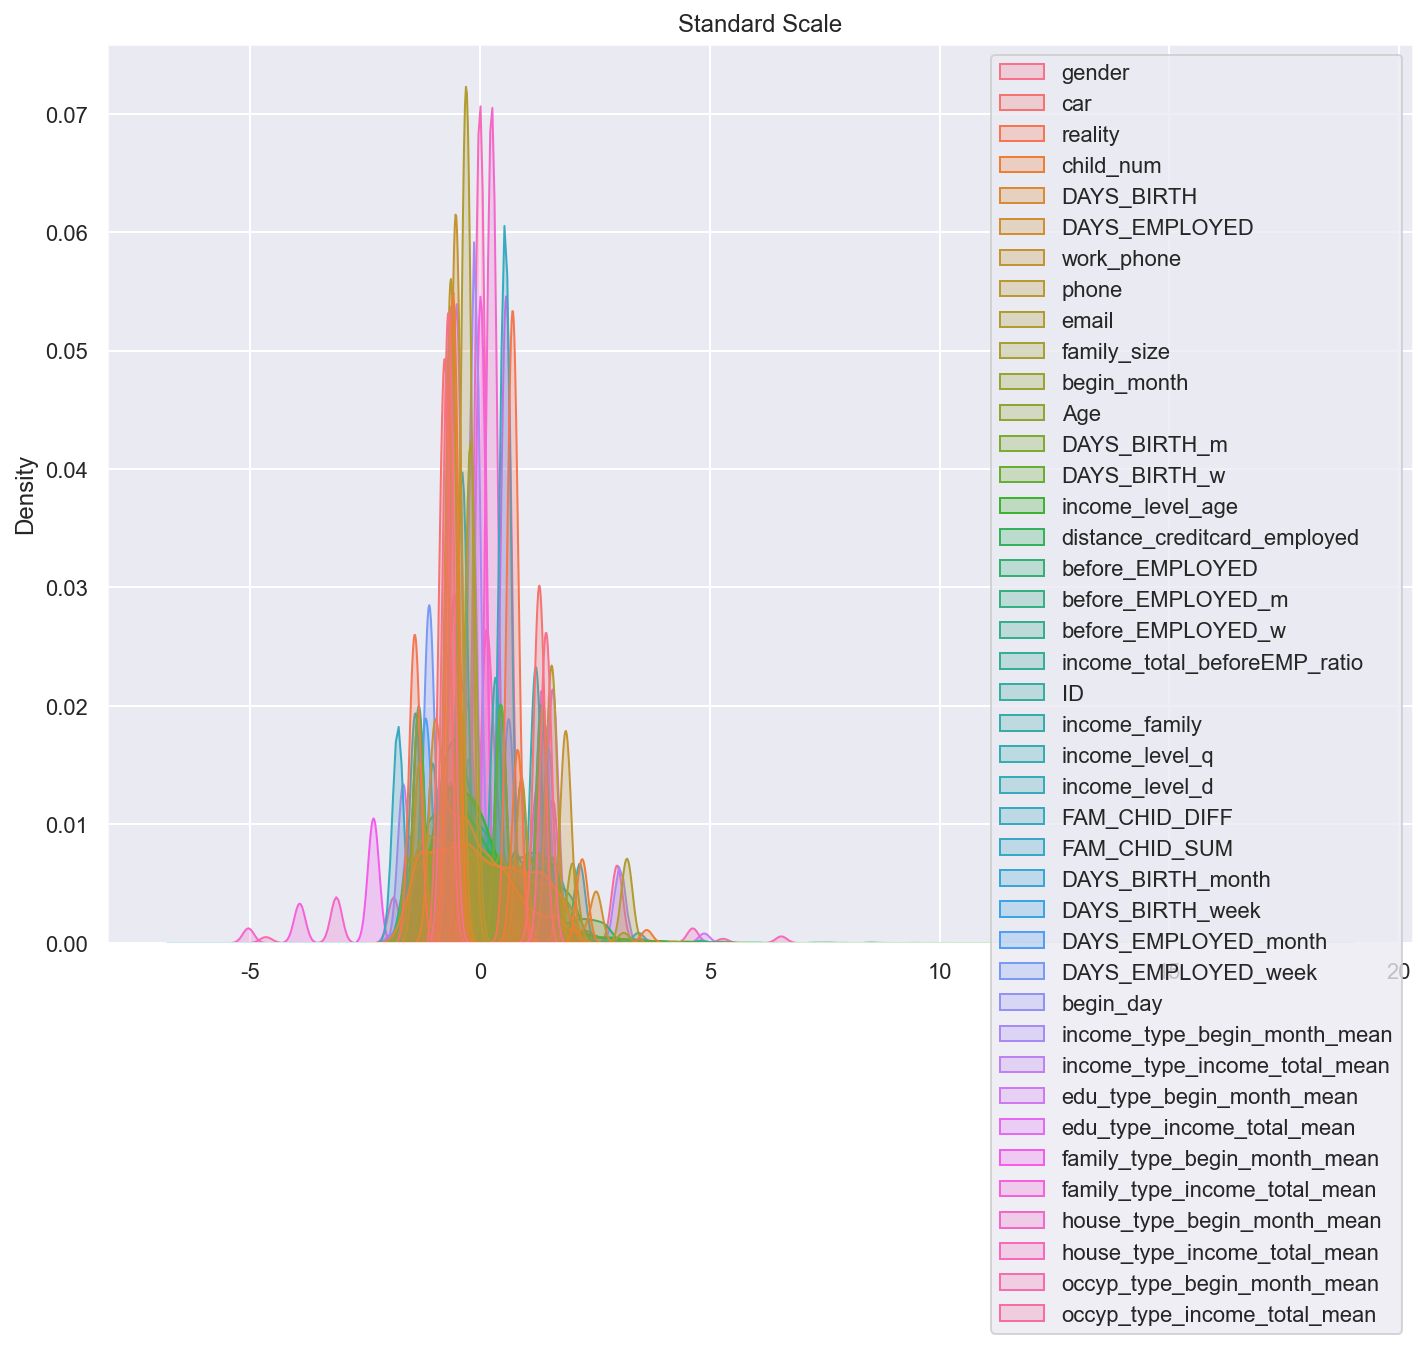

In [273]:
scaler = StandardScaler()
X_view2 = X.copy()
X_view2[numerical_feats] = scaler.fit_transform(X_view2[numerical_feats])

sns.set(rc={'figure.figsize':(11.7,8.27)},)
sns.kdeplot(data = X_view2[numerical_feats], shade = True).set_title('Standard Scale')
plt.show()

### Robust_Scale

- income_total제외한 수치형 변수들 Robust scale

C:\Users\SAMSUNG\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


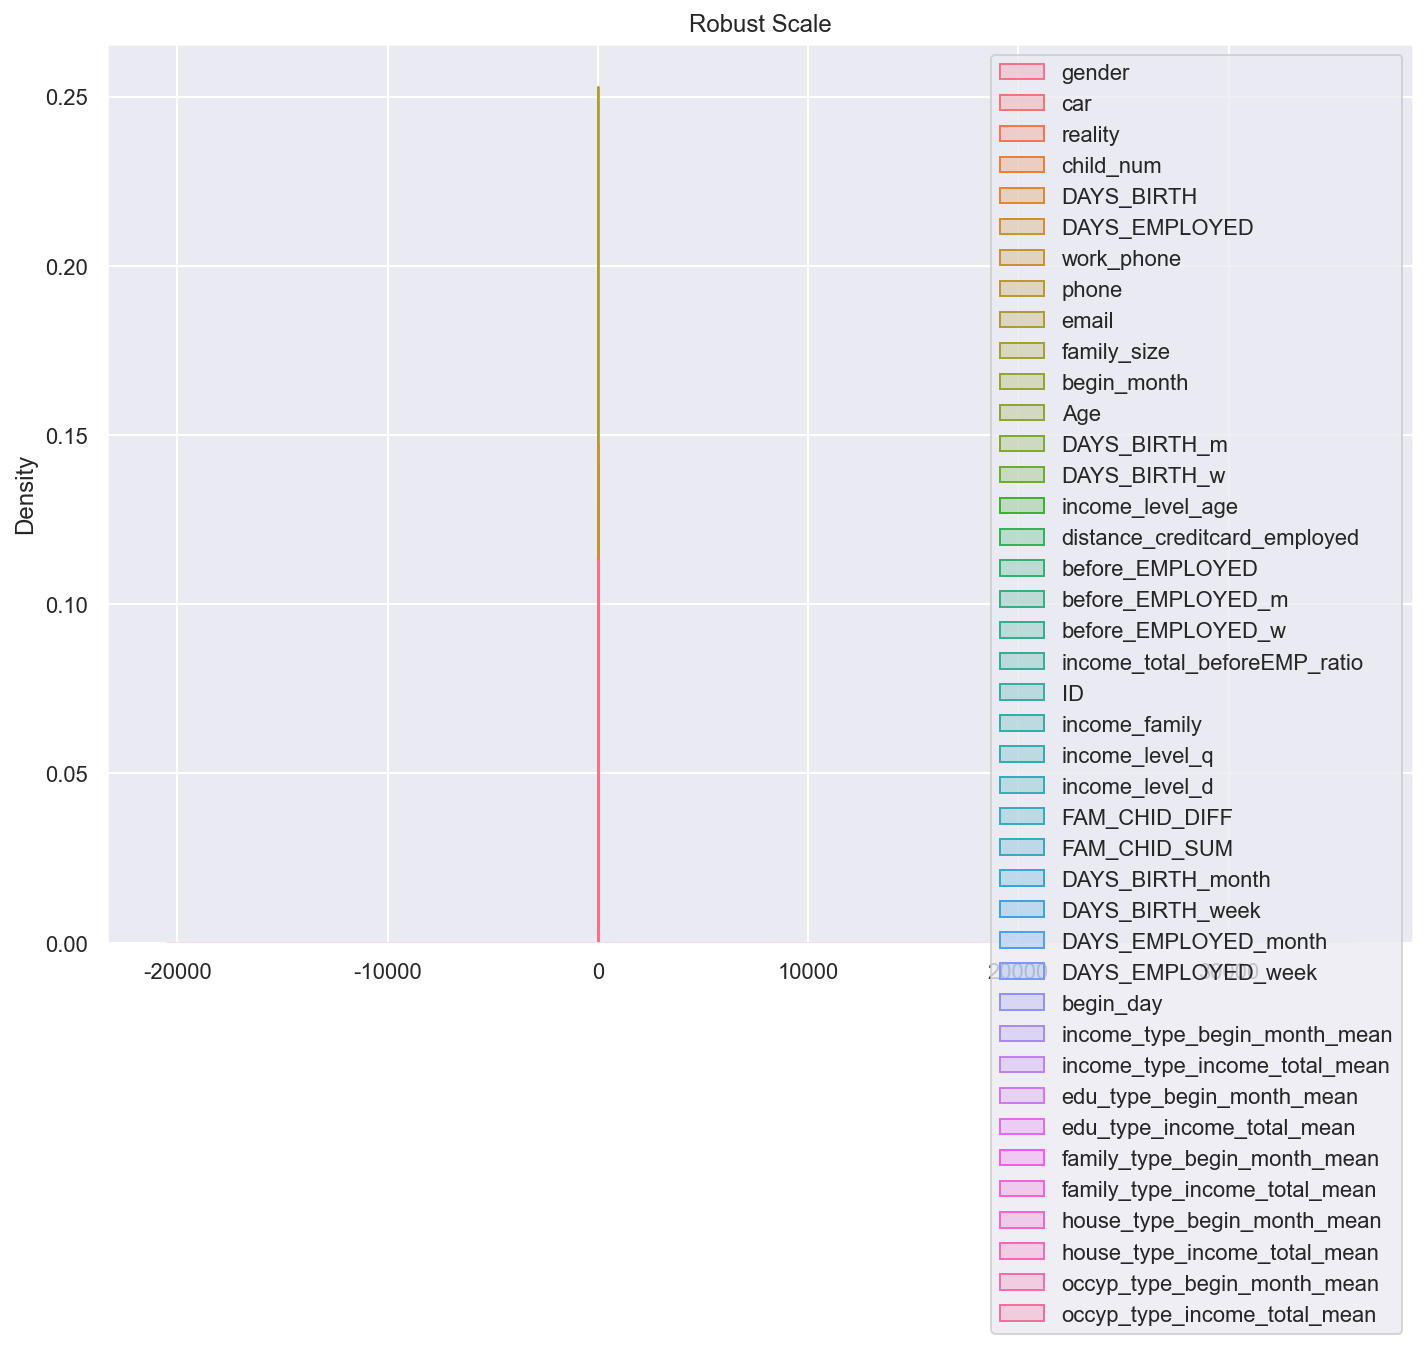

In [274]:
scaler = RobustScaler()
X_view3 = X.copy()
X_view3[numerical_feats] = scaler.fit_transform(X_view3[numerical_feats])

sns.set(rc={'figure.figsize':(11.7,8.27)},)
sns.kdeplot(data = X_view3[numerical_feats], shade = True).set_title('Robust Scale')
plt.show()

### Log_Scale

In [275]:
#income_total log변환
X['income_total'] = np.log1p(1+X['income_total'])

### After_Scale

- 정규화를 가장 잘 시켜준다고 판단한 Minmax scale 결과

C:\Users\SAMSUNG\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


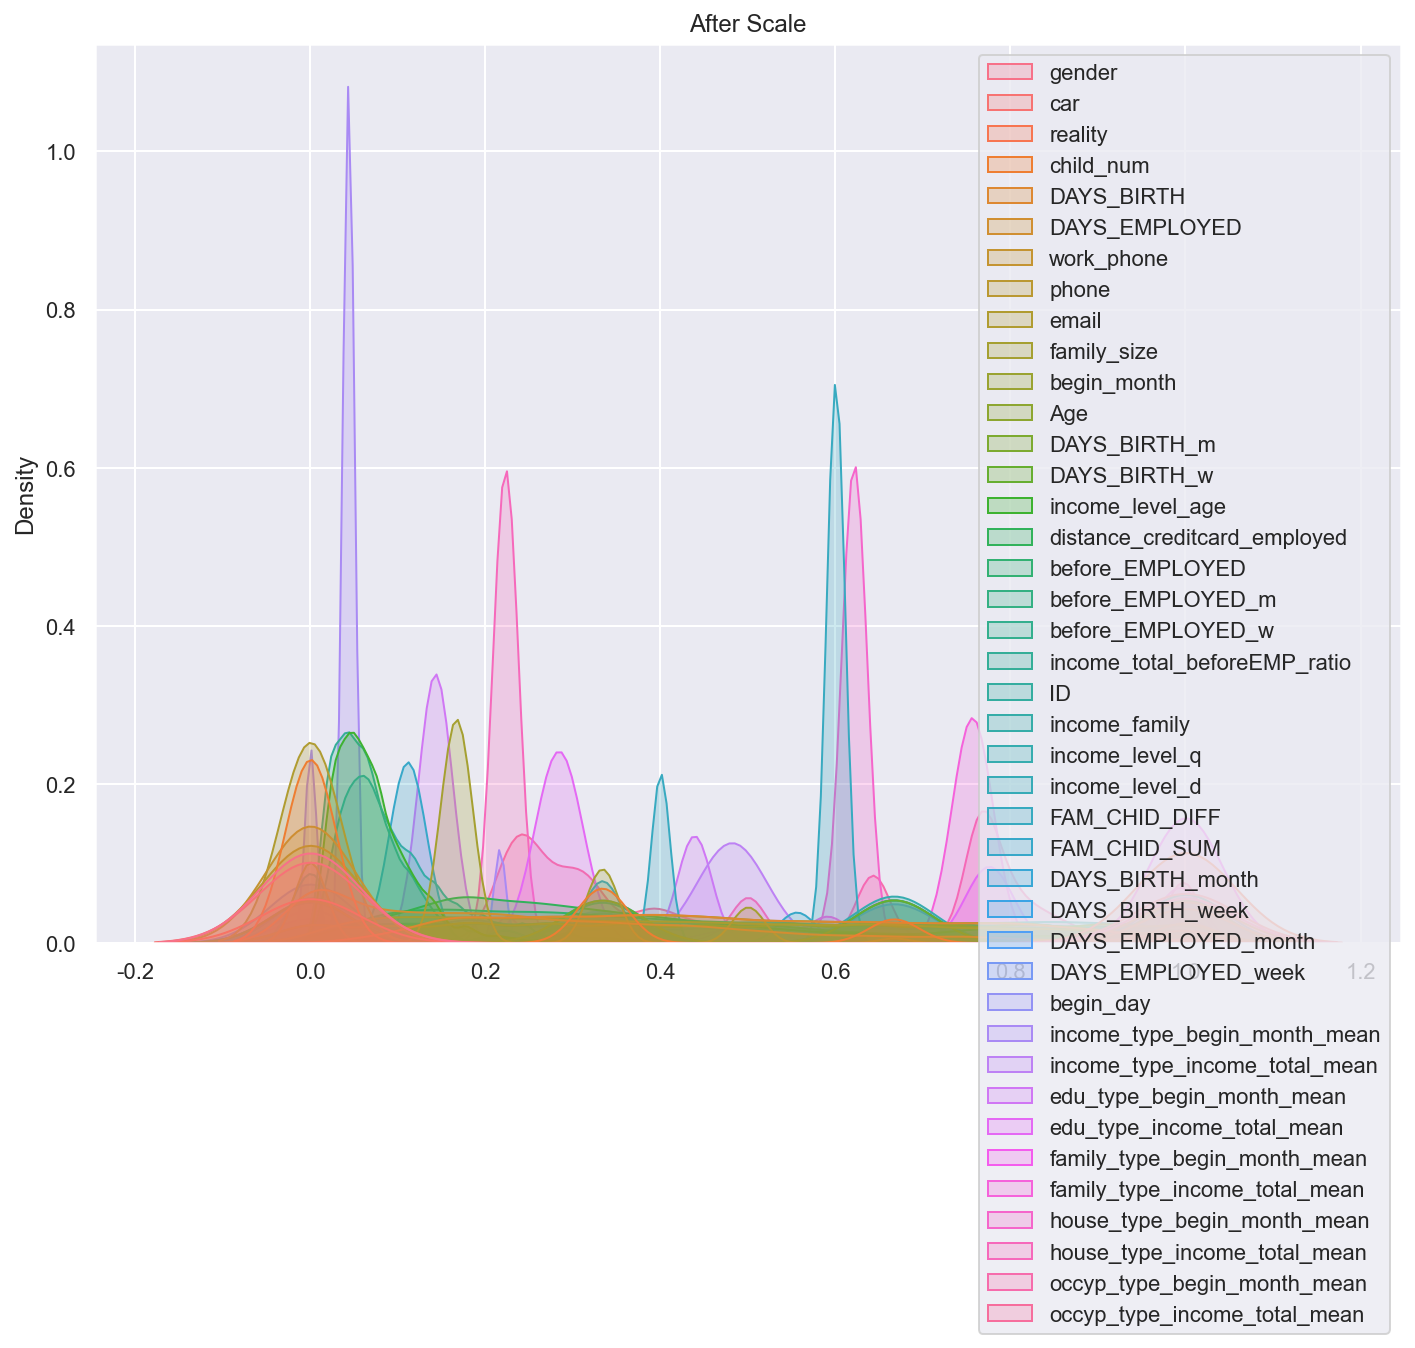

In [276]:
scaler = MinMaxScaler()

X[numerical_feats] = scaler.fit_transform(X[numerical_feats])

sns.set(rc={'figure.figsize':(11.7,8.27)},)
sns.kdeplot(data = X[numerical_feats], shade = True).set_title('After Scale')
plt.show()

# 6. Feature Selection

### corr-method

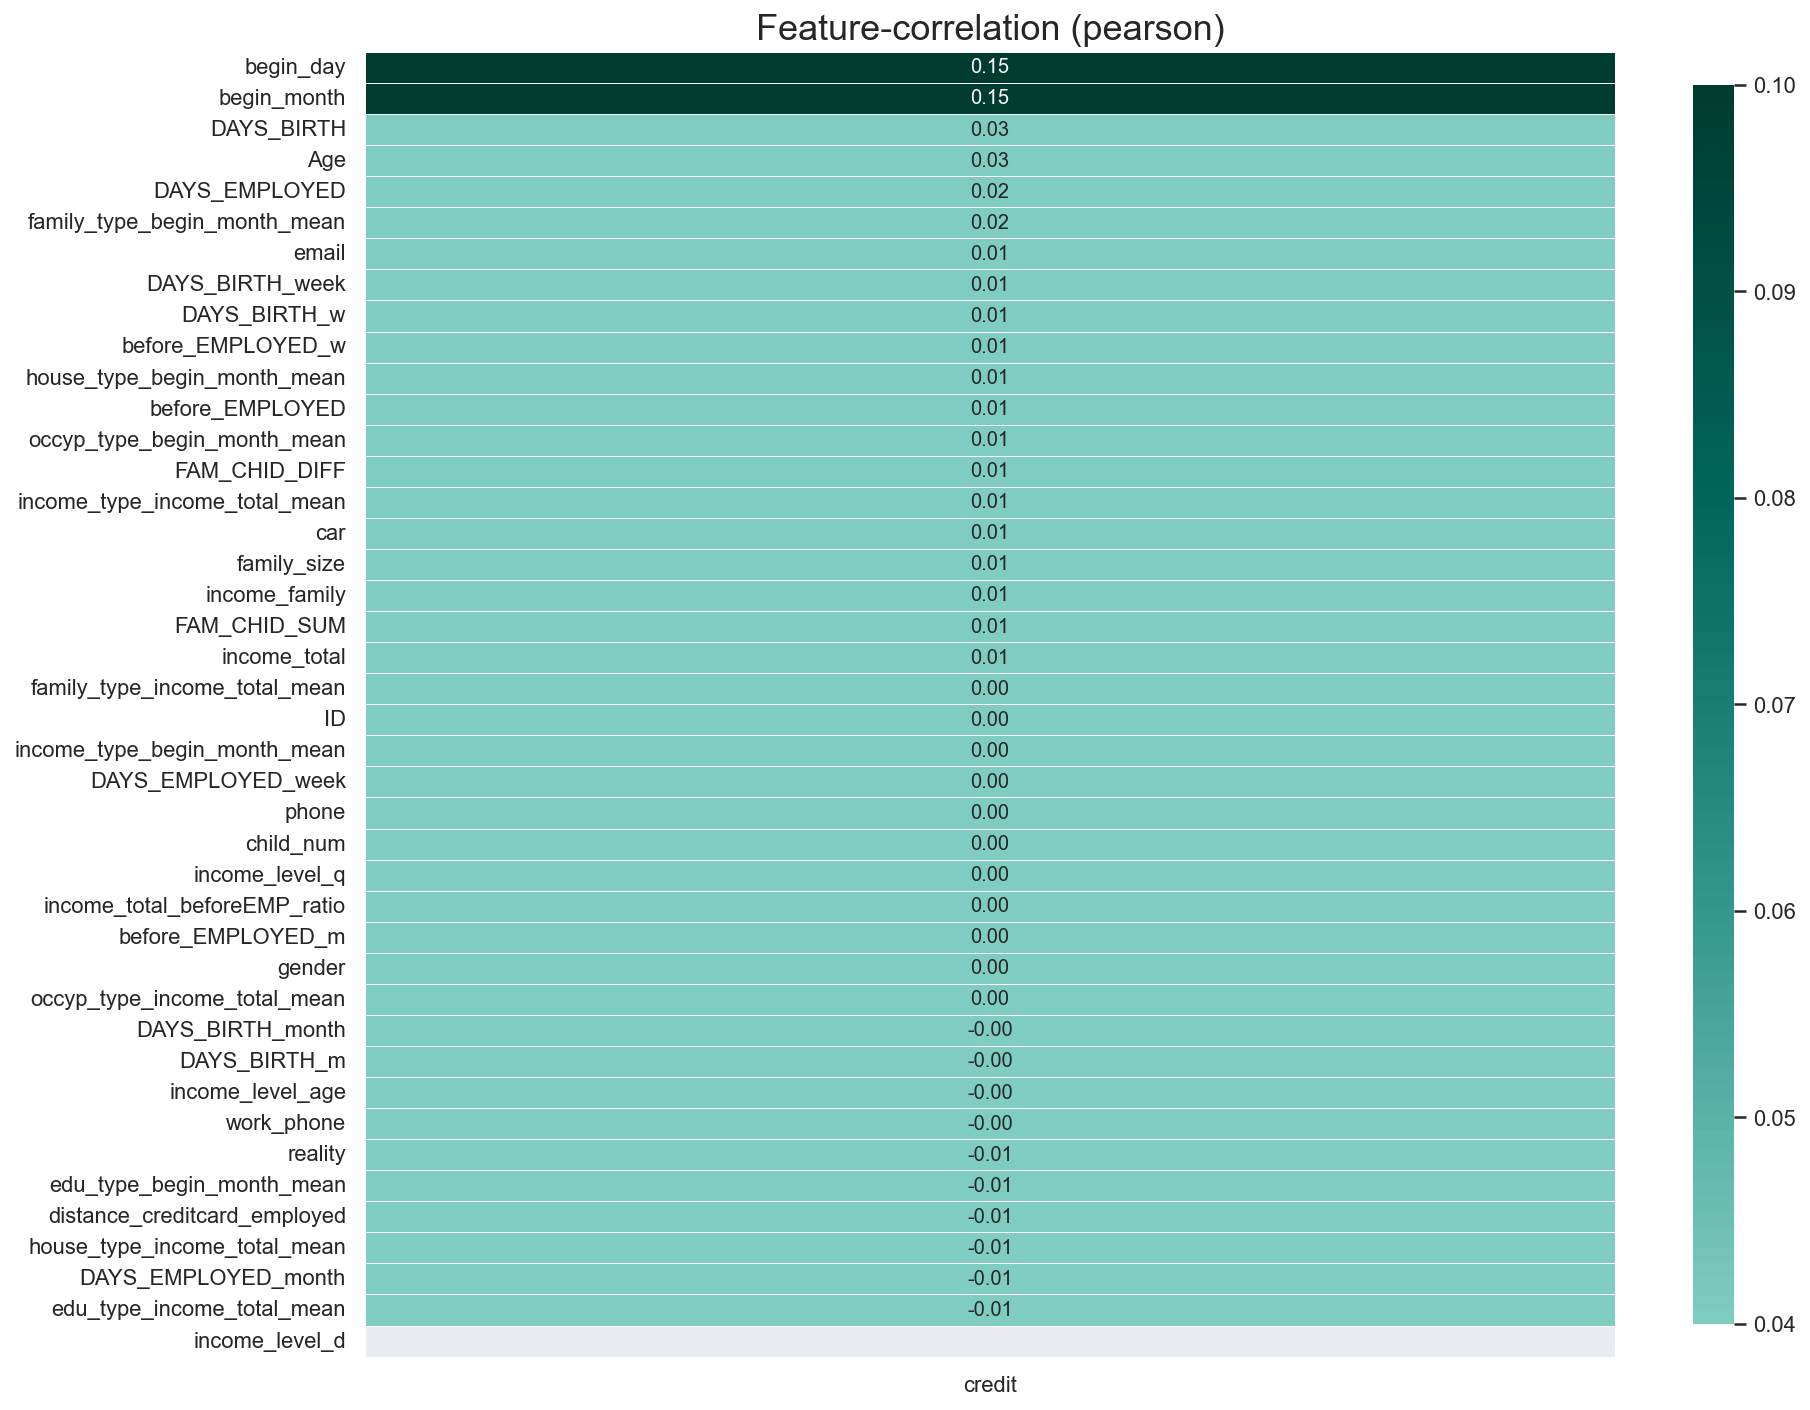

In [277]:
#종속변수 credict와 feature들의 상관계수

X_view = X.iloc[:X_train.shape[0],:]
klib.corr_plot(data = X_view, 
               target = y_train ,
               figsize = (14, 12))

plt.show()

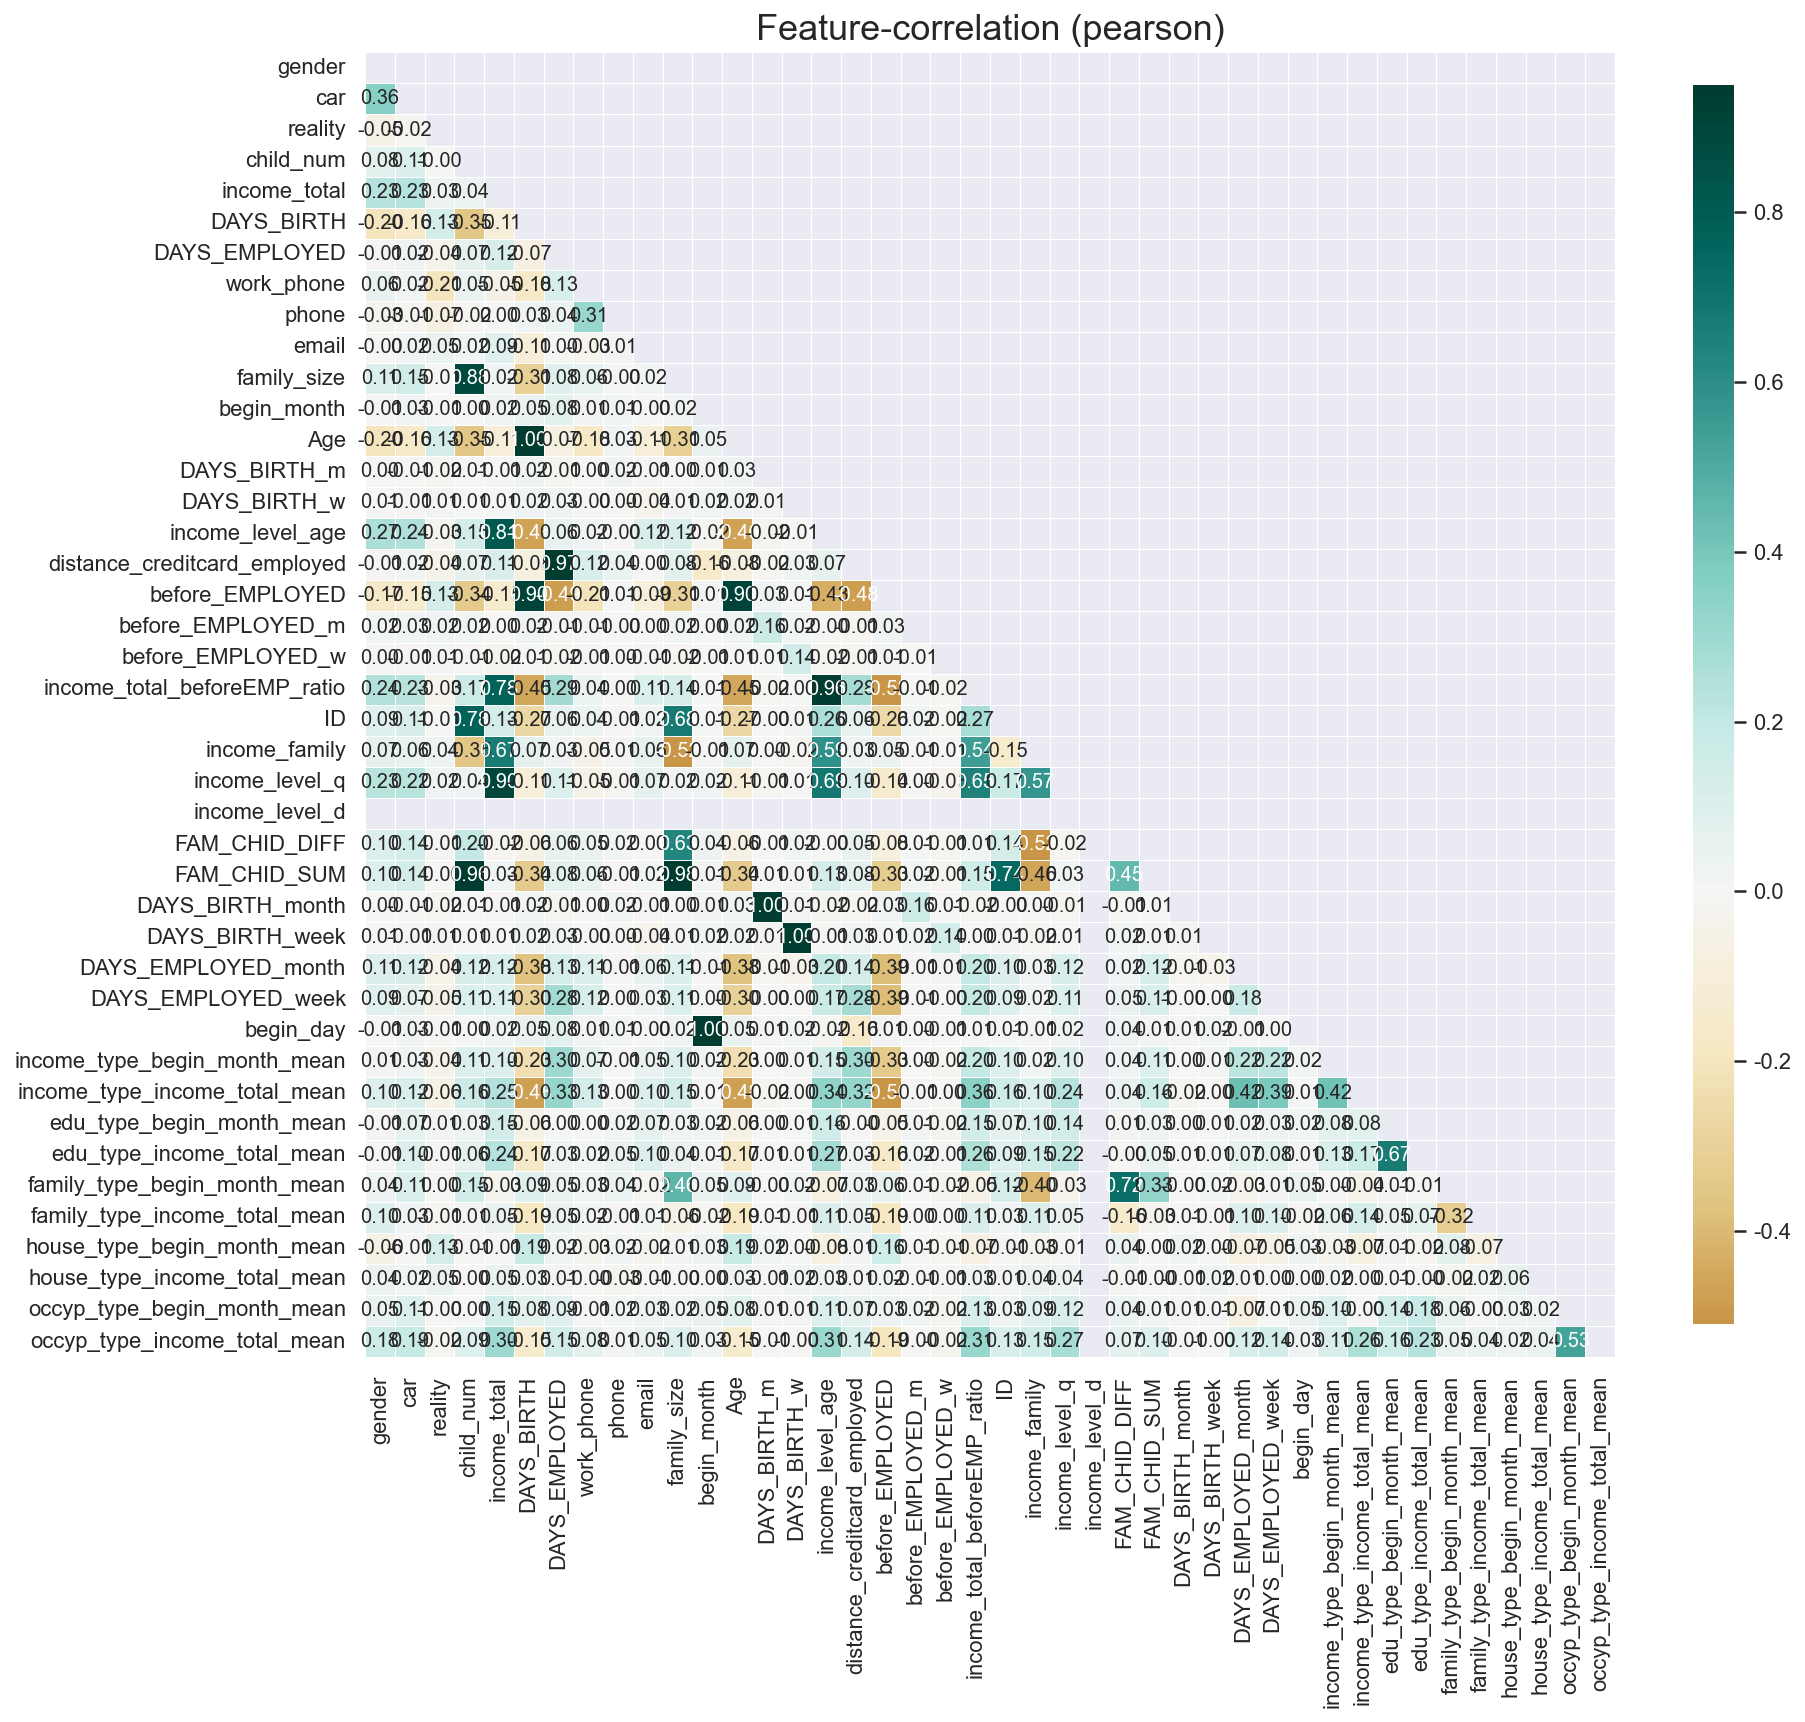

In [278]:
#독립변수들 끼리의 상관관계

klib.corr_plot(data = X,figsize = (14, 12))
plt.show()

### 독립변수 간의 상관성이 강한 변수(다중공선성 존재)

- family_size, child_num
- Age, Days_BIRTH
- DAYS_EMPLOYED, distane_credictcard_employed
- before_EMPLOYED, DAYS_BIRTH
- before_EMPLOYED, Age

### feature-method

In [279]:
# RandomForestClassifier 기반의 feature importance

con = X_view.dtypes[X_view.dtypes != "object"].index.tolist()
rf = RandomForestClassifier()
rf.fit(X_view[con], y_train)

RandomForestClassifier()

In [280]:
feature_import = pd.Series(rf.feature_importances_, X_view[con].columns)

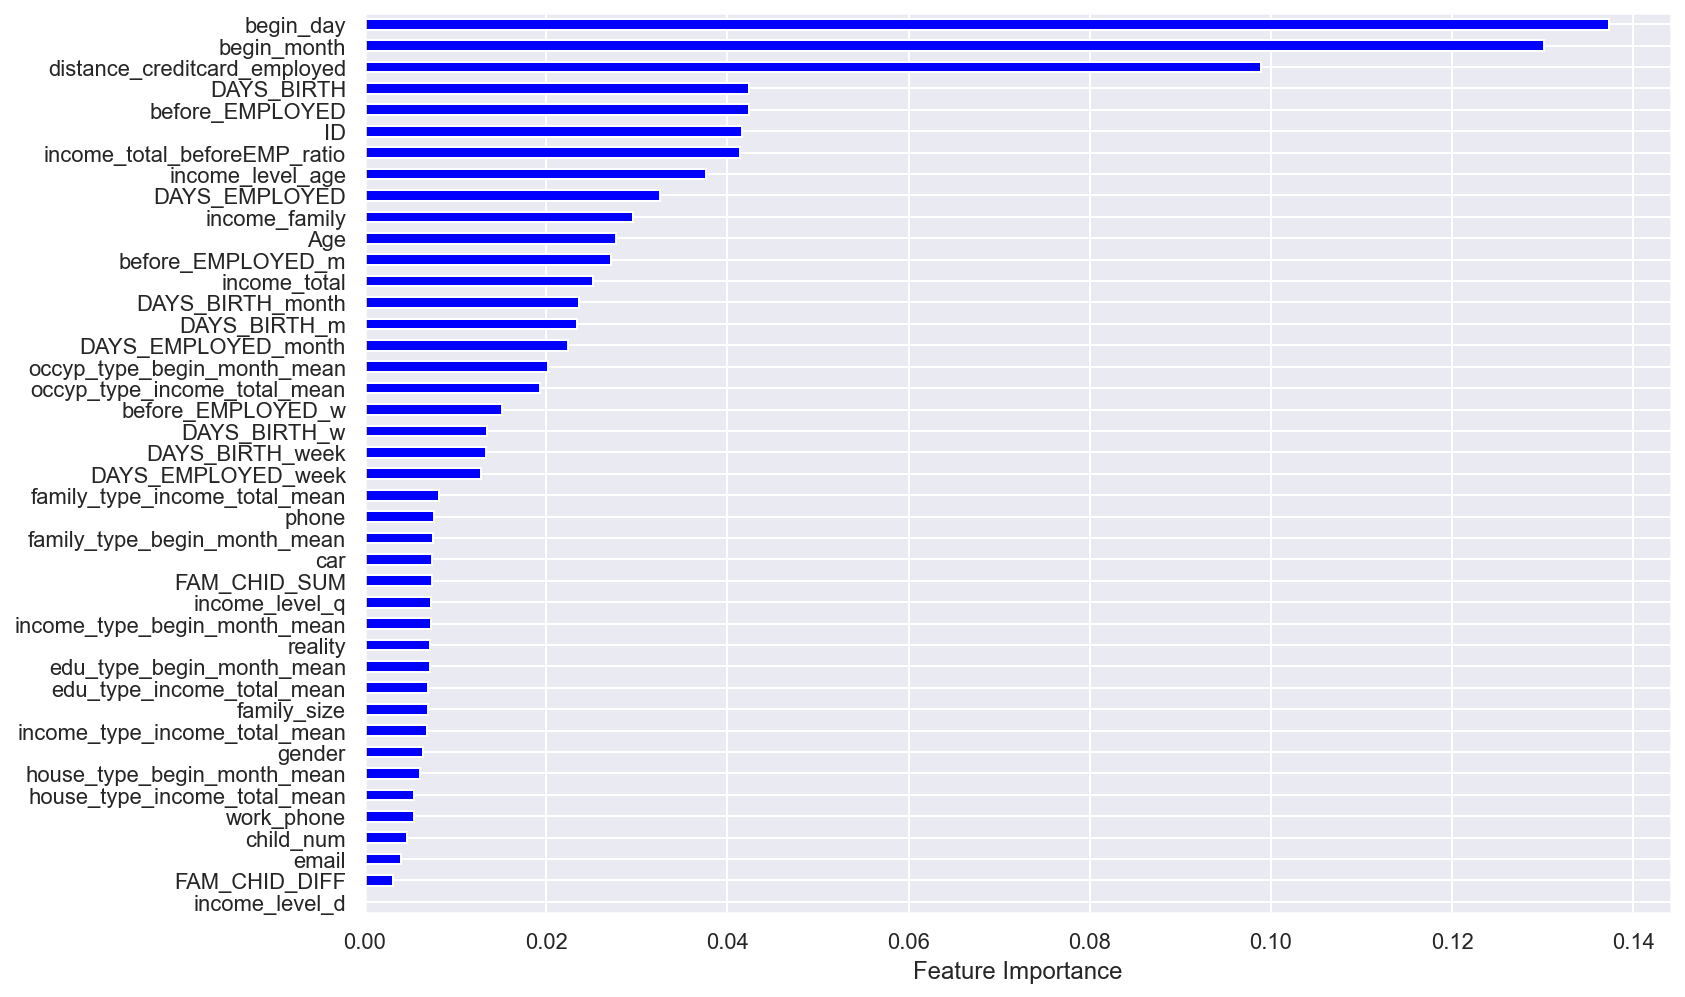

In [281]:
feature_import.sort_values(ascending = True).plot(kind = 'barh', color = 'blue')
plt.xlabel('Feature Importance')
plt.show()

In [282]:
# 다중공선성이 있고 중요도가 낮은 피처 삭제
X.drop('child_num',axis=1,inplace=True)
X.drop('Age',axis=1,inplace=True)
X.columns

Index(['gender', 'car', 'reality', 'income_total', 'income_type', 'edu_type',
       'family_type', 'house_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'work_phone', 'phone', 'email', 'occyp_type', 'family_size',
       'begin_month', 'DAYS_BIRTH_m', 'DAYS_BIRTH_w', 'income_level_age',
       'distance_creditcard_employed', 'before_EMPLOYED', 'before_EMPLOYED_m',
       'before_EMPLOYED_w', 'income_total_beforeEMP_ratio', 'ID',
       'income_family', 'income_level_q', 'income_level_d', 'FAM_CHID_DIFF',
       'FAM_CHID_SUM', 'DAYS_BIRTH_month', 'DAYS_BIRTH_week',
       'DAYS_EMPLOYED_month', 'DAYS_EMPLOYED_week', 'begin_day',
       'income_type_begin_month_mean', 'income_type_income_total_mean',
       'edu_type_begin_month_mean', 'edu_type_income_total_mean',
       'family_type_begin_month_mean', 'family_type_income_total_mean',
       'house_type_begin_month_mean', 'house_type_income_total_mean',
       'occyp_type_begin_month_mean', 'occyp_type_income_total_mean'],
      dtype='

# 7. Modeling

### train,test,features split

In [283]:
X_train = X.iloc[:X_train.shape[0],:].reset_index(drop=True)
X_test = X.iloc[X_train.shape[0]:,:].reset_index(drop=True)
y_train = y_train

In [284]:
X_train.columns

Index(['gender', 'car', 'reality', 'income_total', 'income_type', 'edu_type',
       'family_type', 'house_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'work_phone', 'phone', 'email', 'occyp_type', 'family_size',
       'begin_month', 'DAYS_BIRTH_m', 'DAYS_BIRTH_w', 'income_level_age',
       'distance_creditcard_employed', 'before_EMPLOYED', 'before_EMPLOYED_m',
       'before_EMPLOYED_w', 'income_total_beforeEMP_ratio', 'ID',
       'income_family', 'income_level_q', 'income_level_d', 'FAM_CHID_DIFF',
       'FAM_CHID_SUM', 'DAYS_BIRTH_month', 'DAYS_BIRTH_week',
       'DAYS_EMPLOYED_month', 'DAYS_EMPLOYED_week', 'begin_day',
       'income_type_begin_month_mean', 'income_type_income_total_mean',
       'edu_type_begin_month_mean', 'edu_type_income_total_mean',
       'family_type_begin_month_mean', 'family_type_income_total_mean',
       'house_type_begin_month_mean', 'house_type_income_total_mean',
       'occyp_type_begin_month_mean', 'occyp_type_income_total_mean'],
      dtype='

In [285]:
numeric_features = X_train.dtypes[X_train.dtypes != "object"].index.tolist()
print("Number of Numerical features: ", len(numeric_features))

categorical_features = X_train.dtypes[X_train.dtypes == "object"].index.tolist()
print("Number of Categorical features: ", len(categorical_features))

Number of Numerical features:  40
Number of Categorical features:  5


In [286]:
numeric_features

['gender',
 'car',
 'reality',
 'income_total',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'work_phone',
 'phone',
 'email',
 'family_size',
 'begin_month',
 'DAYS_BIRTH_m',
 'DAYS_BIRTH_w',
 'income_level_age',
 'distance_creditcard_employed',
 'before_EMPLOYED',
 'before_EMPLOYED_m',
 'before_EMPLOYED_w',
 'income_total_beforeEMP_ratio',
 'ID',
 'income_family',
 'income_level_q',
 'income_level_d',
 'FAM_CHID_DIFF',
 'FAM_CHID_SUM',
 'DAYS_BIRTH_month',
 'DAYS_BIRTH_week',
 'DAYS_EMPLOYED_month',
 'DAYS_EMPLOYED_week',
 'begin_day',
 'income_type_begin_month_mean',
 'income_type_income_total_mean',
 'edu_type_begin_month_mean',
 'edu_type_income_total_mean',
 'family_type_begin_month_mean',
 'family_type_income_total_mean',
 'house_type_begin_month_mean',
 'house_type_income_total_mean',
 'occyp_type_begin_month_mean',
 'occyp_type_income_total_mean']

In [287]:
categorical_features

['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type']

In [288]:
numeric_features = X_train.dtypes[X_train.dtypes != "object"].index.tolist()
categorical_features = X_train.dtypes[X_train.dtypes == "object"].index.tolist()
categorical_features.remove('occyp_type')
categorical_features.remove('house_type')
binary_features = ['occyp_type','house_type']

In [289]:
binary_features

['occyp_type', 'house_type']

In [290]:
X_train = X_train[numeric_features+categorical_features+binary_features]  # 순서 주의!!!
X_test = X_test[numeric_features+categorical_features+binary_features]
cat_index = [list(X_train.columns).index(c) for c in categorical_features]

### Pipeline

In [291]:
NFOLDS = 5
SEED = 0
NCOMP = 24
P = 0.05

In [292]:
# 상하한값 제한을 통한 결측값 처리 함수: FunctionTransformer를 통해 호출
def remove_outlier(X, q=0.05):  
    df = pd.DataFrame(X)
    return df.apply(lambda x: x.clip(x.quantile(q), x.quantile(1-q)), axis=0).values

# 회귀분석의 계수검정을 이용한 피처선택 전처리기 클래스
class MyFeatureSelector(TransformerMixin, BaseEstimator):
    # 전처리기 생성 즉, MyFeatureSelector() 호출시 실행
    def __init__(self, p=0.01):
        self.p = p

    # 전처리기의 fit() 호출시 실행
    def fit(self, X, y=None):
        X = sm.add_constant(X)
        results = sm.OLS(y, X).fit()
        self.cols = list(results.pvalues[1:] <= self.p)
        return self
    
    # 전처리기의 transform() 호출시 실행
    def transform(self, X):
        return X[:,self.cols].astype(np.int64)        
    
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("outlier", FunctionTransformer(remove_outlier, kw_args={'q':0.05})),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")), 
        ("encoder", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=99999, dtype=np.object)),
    ]
)

binary_transformer = Pipeline(
    steps=[
        ("impuer", FunctionTransformer(lambda x: x.fillna('없음'))),      
        ("corpus", FunctionTransformer(lambda x: x.str.replace('·',',').str.split(',').str.join(" "))),
        ("BoW", CountVectorizer()),
        ("dense", FunctionTransformer(lambda x: x.toarray().astype(int), accept_sparse=True)),
    ]
)

column_transformer = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
        ("bin1", make_pipeline(binary_transformer, TruncatedSVD(n_components=NCOMP,random_state=SEED)), binary_features[0]),
        ("bin2", make_pipeline(binary_transformer, MyFeatureSelector(p=P)), binary_features[1]),        

    ]
)

preprocessor = Pipeline(
    steps=[
        ("column", column_transformer), 
    ]
)

set_config(display="diagram")
preprocessor

C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_6176\1078355669.py:33: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ("encoder", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=99999, dtype=np.object)),


Pipeline(steps=[('column',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('outlier',
                                                                   FunctionTransformer(func=<function remove_outlier at 0x00000231A05DC040>,
                                                                                       kw_args={'q': 0.05}))]),
                                                  ['gender', 'car', 'reality',
                                                   'income_total', 'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
                                                   'work_phone', 'phone',
                                                   'email', 'family_size',
                                                   'begin_month',
                                                   'DAYS_BIRT...
                                                                   Pipeline(steps=[('impuer',
                                                                                    FunctionTransformer(func=<function <lambda> at 0x000002318E7128B0>)),
                                                                                   ('corpus',
                                                                                    FunctionTransformer(func=<function <lambda> at 0x000002318E712280>)),
                                                                                   ('BoW',
                                                                                    CountVectorizer()),
                                                                                   ('dense',
                                                                                    FunctionTransformer(accept_sparse=True,
                                                                                                        func=<function <lambda> at 0x000002318E6FBDC0>))])),
                                                                  ('myfeatureselector',
                                                                   MyFeatureSelector(p=0.05))]),
                                                  'house_type')]))])

In [293]:
X_train = preprocessor.fit_transform(X_train, y_train)
X_test = preprocessor.transform(X_test)

### catboost

In [294]:
n_est = 2000
seed = 0
n_fold = 5
n_class = 3

X_train = X_train
y_train = y_train

In [295]:
%%time
models = cross_validate(CatBoostClassifier(cat_features=cat_index, verbose=False, random_state=SEED),
                        X_train, y_train, 
                        cv=NFOLDS, 
                        scoring='neg_log_loss', 
                        return_estimator=True)
oof_pred = np.array([m.predict_proba(X_test) for m in models['estimator']]).mean(axis=0)

scores = models['test_score']
print("\nCatBoost CV scores: ", np.sqrt(-1*scores))
print("CatBoost CV mean = %.2f" % np.sqrt(-1*scores.mean()), "with std = %.2f" % np.sqrt(scores.std()))


CatBoost CV scores:  [0.8474429  0.85444788 0.85488287 0.8559251  0.85305732]
CatBoost CV mean = 0.85 with std = 0.07
CPU times: total: 16min 54s
Wall time: 3min 30s


In [296]:
CATBOOST_VERSION = 16.0

In [297]:
# # submission 화일 생성
# filename = f'catboost_{CATBOOST_VERSION}_{np.sqrt(-1*scores.mean()):.6f}.csv'
# index = submission['index']
# pd.DataFrame({'index':index,'0':oof_pred[:,0],'1':oof_pred[:,1],'2':oof_pred[:,2]}).to_csv(filename, index=False)